# Astrometric precision horizons

SHow the distance limits for the relative precision on parallaxes and proper motions. The plots produced are similar to figure 10 in [Brown (2021)](https://ui.adsabs.harvard.edu/abs/2021ARA%26A..59...59B/abstract) which is in turn based on figure 15 in [Mateu et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.469..721M/abstract).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

from pygaia.astrometry.constants import au_km_year_per_sec
from pygaia.errors.astrometric import (
    total_proper_motion_uncertainty,
    parallax_uncertainty,
)
from pygaia.photometry.transformations import gminic_from_vminic

plt.style.use("./agab.mplstyle")

## Define absolute $G$-band magnitudes of a few tracer populations.

|Population | Characteristic $M_G$ |
| --- | --- |
|Main sequence turn-off | $3.5$ |
|Horizontal Branch | $0.5$ |
|Tip of the Red Giant Branch | $-3.1$ |

For the TRGB the value of $M_G$ is calculated from $(V-I_\mathrm{c})=1.5$ and $M_{I_\mathrm{c}}=-4$.

In [2]:
gabs_msto = 3.5
gabs_hb = 0.5
vminic_trgb = 1.5
icabs_trgb = -4.0
gabs_trgb = gminic_from_vminic(vminic_trgb) + icabs_trgb

## Relative proper motion uncertainty as a function of distance from the solar system barycentre

The plot below is made for an estimate of typical tangential velocities which are calculated according to footnote 4 in [Mateu et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017MNRAS.469..721M/abstract).

"We assume that the radial velocity is on average $v_r \sim v/\sqrt{3}$ and the total
proper motion $\mu \sim \sqrt{2/3}v$, where we assume $v \sim v_\mathrm{e}/2$ and approximate
the escape velocity as $v_\mathrm{e} = v_\mathrm{c} \sqrt{2(1 − \ln(R_\mathrm{gal}/r_\mathrm{t}))}$, with $v_\mathrm{c} = 200$ km s$^{−1}$,
$r_\mathrm{t} = 200$ kpc and $R_\mathrm{gal}$ the Galactocentric distance."

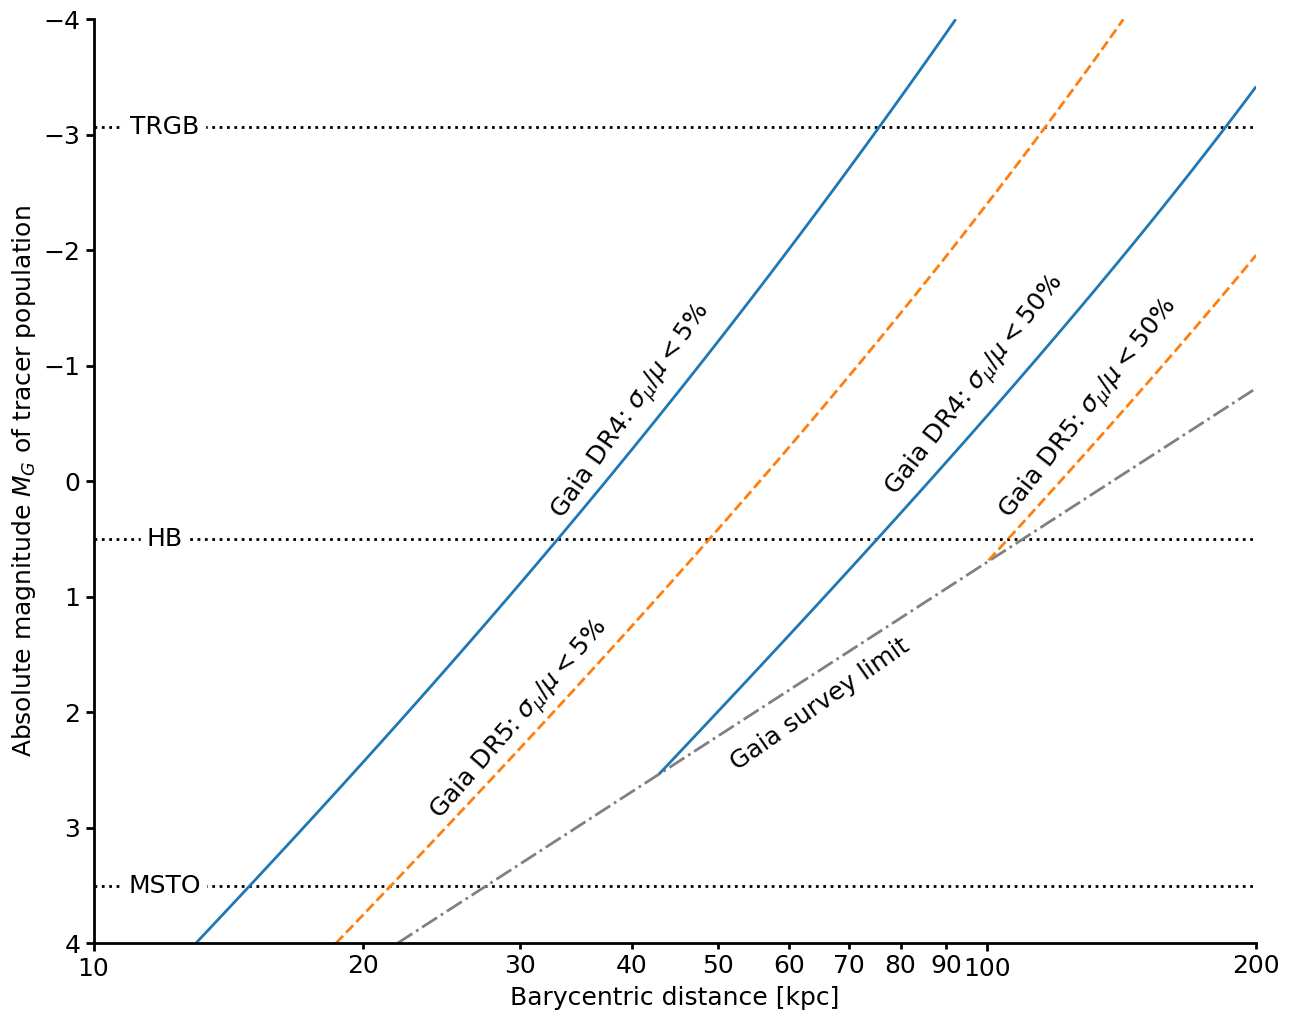

In [3]:
gabs = np.linspace(-4, 4, 1000)
rhel = np.logspace(np.log10(10000), np.log10(200000), 1000)
mabsg, r = np.meshgrid(gabs, rhel)

mg = mabsg + 5 * np.log10(r) - 5
proper_motion_unc_dr4 = total_proper_motion_uncertainty(mg, release="dr4")
proper_motion_unc_dr5 = total_proper_motion_uncertainty(mg, release="dr5")

# Code lines below follow footnote 4 in Mateu et al. (2017)
vc = 200
rt = 200000
rsun = 8500
rGal = np.sqrt(r**2 + rsun**2)
ve = vc * np.sqrt(2 * (1 - np.log(rGal / rt)))

vtan = np.sqrt(2.0 / 3.0) * ve / 2
proper_motion = vtan / (r * au_km_year_per_sec) * 1.0e6
rel_pm_unc_dr4 = proper_motion_unc_dr4 / proper_motion
rel_pm_unc_dr5 = proper_motion_unc_dr5 / proper_motion

indices = np.where(mg > 20.7)
rel_pm_unc_dr4[indices] = np.nan
rel_pm_unc_dr5[indices] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

for y in [gabs_trgb, gabs_hb, gabs_msto]:
    ax.plot(
        [rhel.min() / 1000, rhel.max() / 1000],
        [y, y],
        lw=2,
        ls="dotted",
        color="k",
        zorder=-1,
    )
ax.contour(rhel / 1000, gabs, mg.T, levels=[20.7], linestyles="dashdot", colors="gray")
ax.contour(
    rhel / 1000,
    gabs,
    rel_pm_unc_dr4.T,
    levels=[0.05, 0.5],
    colors=colors.to_rgba_array(cm.tab10.colors[0]),
    linestyles=["solid"],
)
ax.contour(
    rhel / 1000,
    gabs,
    rel_pm_unc_dr5.T,
    levels=[0.05, 0.5],
    colors=colors.to_rgba_array(cm.tab10.colors[1]),
    linestyles=["dashed"],
)
ax.invert_yaxis()
ax.set_xscale("log")
ax.set_xticks([10, 100], minor=False)
ax.set_xticklabels(["10", "100"], minor=False)
ax.set_xticks([20, 30, 40, 50, 60, 70, 80, 90, 200], minor=True)
ax.set_xticklabels(["20", "30", "40", "50", "60", "70", "80", "90", "200"], minor=True)
ax.set_xlabel(r"Barycentric distance [kpc]")
ax.set_ylabel(r"Absolute magnitude $M_G$ of tracer population")
ax.text(
    12, gabs_msto, "MSTO", ha="center", va="center", bbox=dict(facecolor="w", ec="w")
)
ax.text(12, gabs_hb, "HB", ha="center", va="center", bbox=dict(facecolor="w", ec="w"))
ax.text(
    12, gabs_trgb, "TRGB", ha="center", va="center", bbox=dict(facecolor="w", ec="w")
)

ax.text(65, 2.5, "Gaia survey limit", ha="center", rotation=35)
ax.text(40, 0.3, r"Gaia DR4: $\sigma_\mu/\mu<5$%", ha="center", rotation=55)
ax.text(30, 2.9, r"Gaia DR5: $\sigma_\mu/\mu<5$%", ha="center", rotation=49)
ax.text(97, 0.1, r"Gaia DR4: $\sigma_\mu/\mu<50$%", ha="center", rotation=52)
ax.text(130, 0.3, r"Gaia DR5: $\sigma_\mu/\mu<50$%", ha="center", rotation=52)

plt.show()

## Relative parallax uncertainty horizons

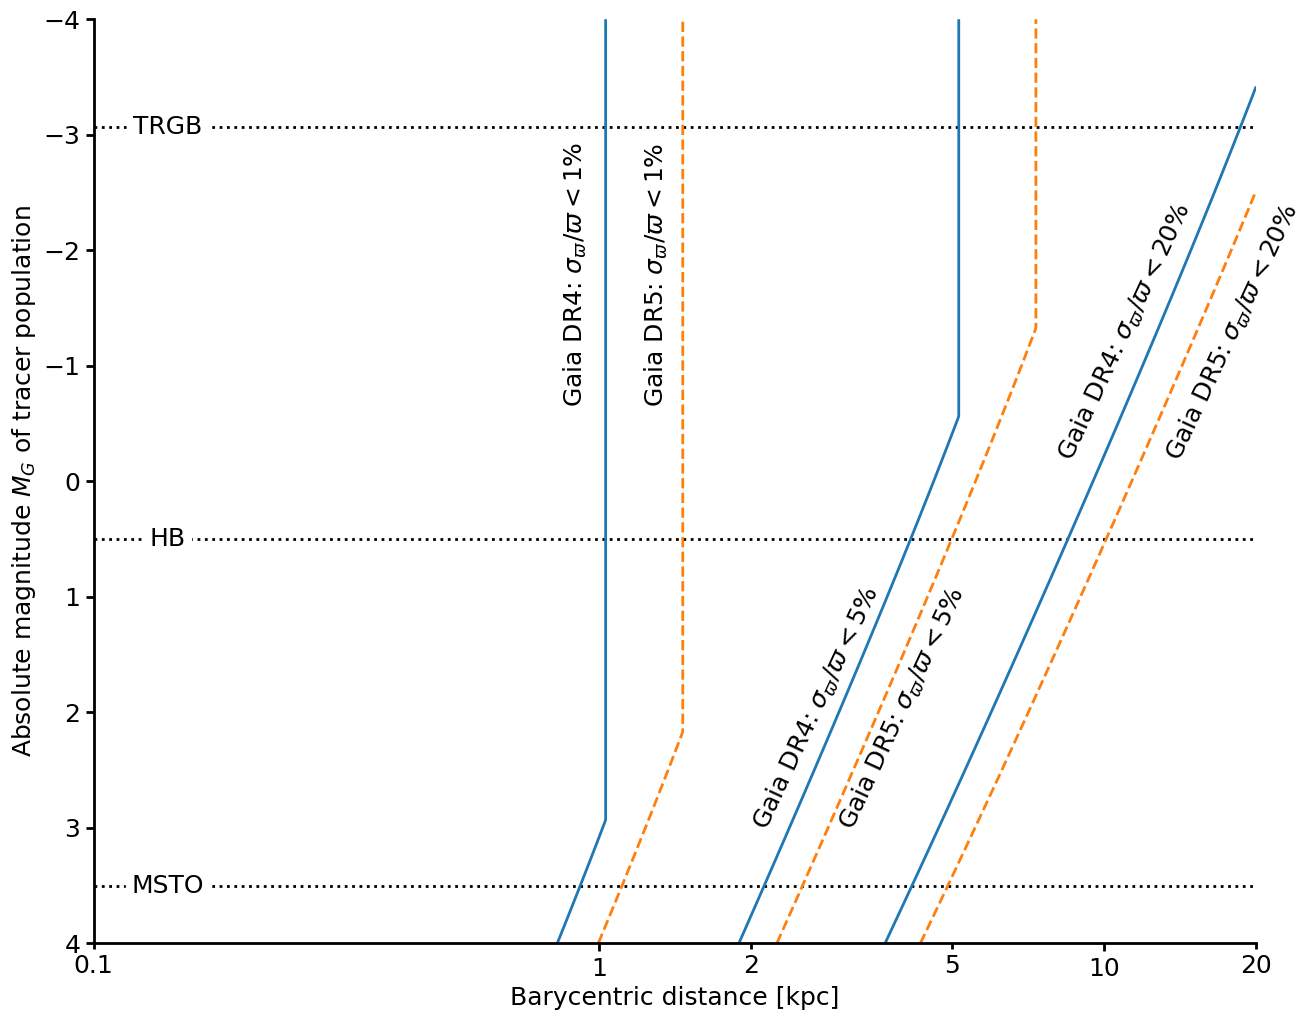

In [4]:
rhel_plx = np.logspace(np.log10(100), np.log10(20000), 1000)
mabsg, r_plx = np.meshgrid(gabs, rhel_plx)
mg_plx = mabsg + 5 * np.log10(r_plx) - 5
plx_unc_dr4 = parallax_uncertainty(mg_plx, release="dr4")
plx_unc_dr5 = parallax_uncertainty(mg_plx, release="dr5")
rel_plx_unc_dr4 = plx_unc_dr4 * r_plx / 1.0e6
rel_plx_unc_dr5 = plx_unc_dr5 * r_plx / 1.0e6

indices = np.where(mg_plx > 20.7)
rel_plx_unc_dr4[indices] = np.nan
rel_plx_unc_dr5[indices] = np.nan

fig, axplx = plt.subplots(1, 1, figsize=(15, 12))

for y in [gabs_trgb, gabs_hb, gabs_msto]:
    axplx.plot(
        [rhel_plx.min() / 1000, rhel_plx.max() / 1000],
        [y, y],
        lw=2,
        ls="dotted",
        color="k",
        zorder=-1,
    )
axplx.contour(
    rhel_plx / 1000,
    gabs,
    rel_plx_unc_dr4.T,
    levels=[0.01, 0.05, 0.2],
    colors=colors.to_rgba_array(cm.tab10.colors[0]),
    linestyles=["solid"],
)
axplx.contour(
    rhel_plx / 1000,
    gabs,
    rel_plx_unc_dr5.T,
    levels=[0.01, 0.05, 0.2],
    colors=colors.to_rgba_array(cm.tab10.colors[1]),
    linestyles=["dashed"],
)
axplx.invert_yaxis()
axplx.set_xscale("log")
axplx.set_xticks([1, 10], minor=False)
axplx.set_xticklabels(["1", "10"], minor=False)
axplx.set_xticks([0.1, 1, 2, 5, 10, 20], minor=True)
axplx.set_xticklabels(["0.1", "1", "2", "5", "10", "20"], minor=True)
axplx.set_xlabel(r"Barycentric distance [kpc]")
axplx.set_ylabel(r"Absolute magnitude $M_G$ of tracer population")
axplx.text(
    0.14, gabs_msto, "MSTO", ha="center", va="center", bbox=dict(facecolor="w", ec="w")
)
axplx.text(
    0.14, gabs_hb, "HB", ha="center", va="center", bbox=dict(facecolor="w", ec="w")
)
axplx.text(
    0.14, gabs_trgb, "TRGB", ha="center", va="center", bbox=dict(facecolor="w", ec="w")
)

axplx.text(0.9, -0.7, r"Gaia DR4: $\sigma_\varpi/\varpi<1$%", ha="center", rotation=90)
axplx.text(1.3, -0.7, r"Gaia DR5: $\sigma_\varpi/\varpi<1$%", ha="center", rotation=90)
axplx.text(2.7, 3, r"Gaia DR4: $\sigma_\varpi/\varpi<5$%", ha="center", rotation=65)
axplx.text(4, 3, r"Gaia DR5: $\sigma_\varpi/\varpi<5$%", ha="center", rotation=65)
axplx.text(11, -0.2, r"Gaia DR4: $\sigma_\varpi/\varpi<20$%", ha="center", rotation=65)
axplx.text(18, -0.2, r"Gaia DR5: $\sigma_\varpi/\varpi<20$%", ha="center", rotation=65)

plt.show()